<a href="https://colab.research.google.com/github/jairock007/Assignment_of_Bluejay-Delivery/blob/main/Copy_of_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Read the data
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')

In [ ]:
df = df.head(10000)

In [ ]:
# Drop rows with missing values if necessary
df.dropna(inplace=True)

In [ ]:
# Check for merchants and remove their data
df = df[~df['nameDest'].str.startswith('M')]

In [ ]:
# Define features (X) and target (y)
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

In [ ]:
# Label encode categorical variables
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

In [ ]:
# Check for multicollinearity using VIF and drop correlated features
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [ ]:
# Drop highly correlated features based on VIF
X = X.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)


In [ ]:
# Perform train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [ ]:
# Normalize 'amount' feature
scaler = StandardScaler()
X_train['amount'] = scaler.fit_transform(X_train[['amount']])
X_val['amount'] = scaler.transform(X_val[['amount']])
X_test['amount'] = scaler.transform(X_test[['amount']])

In [ ]:
# Train Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Train Random Forest Classifier with GridSearchCV for fine-tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_


In [ ]:
# Calibrate the Random Forest classifier
calibrated_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_val, y_val)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(n_estimators=50,
                                                        random_state=42))

In [ ]:
# Predictions
y_pred_dt = decision_tree.predict(X_test)
y_pred_rf = calibrated_rf.predict(X_test)

In [ ]:
# Model evaluation
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.20      0.13      0.16        15

    accuracy                           0.98       907
   macro avg       0.59      0.56      0.57       907
weighted avg       0.97      0.98      0.97       907

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       892
           1       1.00      0.07      0.12        15

    accuracy                           0.98       907
   macro avg       0.99      0.53      0.56       907
weighted avg       0.98      0.98      0.98       907



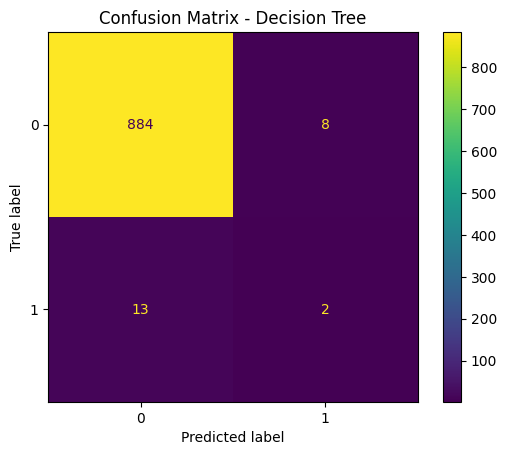

In [ ]:
# Confusion matrix visualization - Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot()
plt.title('Confusion Matrix - Decision Tree')
plt.show()

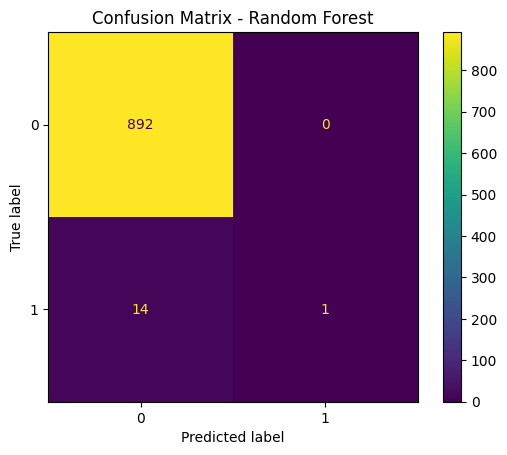

In [ ]:
# Confusion matrix visualization - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [ ]:
# Interpretation: Analyze feature importances
feature_importances = pd.DataFrame(best_rf.feature_importances_,
                                   index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

Feature Importances:
                importance
amount            0.371905
nameDest          0.252274
nameOrig          0.232477
type              0.073935
step              0.069409
isFlaggedFraud    0.000000
